# Sheet

# **1. Introduction to dataset**

The KITTI dataset is a popular benchmark for computer vision tasks and autonomous driving. It has images and annotations that are utilized for object detection, tracking, and other tasks among others. The dataset consists of:

                                                             - Images                                         
                                                             - Labels
                                                             - Format
The dataset is divided into two sets: training and testing. The training set includes photos and labels, while the testing set just contains images for evaluation.  

# **2.Analysis of the Dataset (EDA)**

**Dataset Statistics**

Number of Images : The dataset is consists of approximately 7481 training images and ......  testing images.

Image resolution :

Color Distribution:

Class distribution:

      Cars:

      Pedestrian

      Cyclists


**Bounding Box Analysis**


**Visualization**


# **3.Dataset Preparation**

Pre-processing


Data Augmentation


Data Splitting

# **4.Method Chosen and Why**

**Model Selection**

YOLO8 - YOLO(You Only Look Once) algorithm was chosen due to its high-performance speed and accuracy in object detection applications in real time. It is perfect for autonomous driving where immediate performance is required.


# 5. Training Process

**Training Setup**



**Training Steps**



**Training Duration**




# 6. Analysis of the Training

**Training Loss**

Initial Loss: 

Final Loss:

**Validation Loss**

Initial Validation Loss:

Final Validation Loss:

**Learning Rate Scheduling**

# 7. Analysis of the Results

Accuracy :

Speed :

mAP(Mean Average Precision):




In [1]:
import os
import gc
import cv2
import csv
import glob
import torch
import numpy as np
from PIL import Image
from tqdm import tqdm
import albumentations as  A
from ultralytics import YOLO
import matplotlib.pyplot as plt
from collections import Counter
from albumentations.pytorch import ToTensorV2
from concurrent.futures import ThreadPoolExecutor



Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/home/datalore/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


/opt/python/envs/default/lib/python3.8/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 2.0.5 (you have 1.4.18). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
image_dir = "/data/notebook_files/training/processed_images"
label_dir = "/data/notebook_files/training/label_2"

TRAINING_IMAGE_DIR = "/data/notebook_files/kitti_dataset/images/train/image_2"
TRAINING_PREPROCESED_IMAGE_DIR = "/data/notebook_files/kitti_dataset/images/train/processed_images"
TRAINING_LABEL_DIR = "/data/notebook_files/kitti_dataset/labels/train/label_2"

classes = {"Pedestrian":0, "Truck":1, "Car":2, "Cyclist": 3, "DontCare": 4, "Misc": 5, "Van": 6, "Tram": 7, "Person_sitting": 8}

# Dataset

## Show the first image with bounding boxes

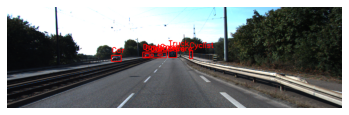

In [15]:
image_path = os.path.join(TRAINING_IMAGE_DIR, "000001.png")
label_path = os.path.join(TRAINING_LABEL_DIR, "000001.txt")

def show_image_with_bounding_boxes(image_path: str, label_path: str): 
    image = cv2.imread(image_path)
    if image is None:
        raise FileNotFoundError(f"Error: Could not load image at {image_path}.")

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    height, width, _ = image.shape  # Image dimensions

    if not os.path.exists(label_path):
        raise FileNotFoundError(f"Error: Could not find label file at {label_path}.")

    with open(label_path, "r") as f:
        labels = f.readlines()

    for label in labels:
        parts = label.split()
        if len(parts) < 8:
            print(f"Skipping malformed label: {label}")
            continue  # Skip incorrectly formatted lines

        class_name = parts[0]
        x1, y1, x2, y2 = map(float, [parts[4], parts[5], parts[6], parts[7]])

        # If the coordinates are normalized (values between 0 and 1), convert them to actual pixel values
        if x1 < 1 and y1 < 1 and x2 < 1 and y2 < 1:
            x1, y1, x2, y2 = int(x1 * width), int(y1 * height), int(x2 * width), int(y2 * height)
        else:
            x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)

        cv2.rectangle(image, (x1, y1), (x2, y2), (255, 0, 0), 2)
        cv2.putText(image, class_name, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)

    plt.imshow(image)
    plt.axis("off")
    plt.show()

show_image_with_bounding_boxes(image_path, label_path)

In [4]:
class_counts = Counter()
bbox_sizes = []

label_files = sorted(os.listdir(TRAINING_LABEL_DIR))[:1000]  # Process up to 1000 labels

for lbl_file in tqdm(label_files, desc="Processing Images"):
    label_path = os.path.join(TRAINING_LABEL_DIR, lbl_file)

    with open(label_path, "r") as f:
        labels = f.readlines()

    for label in labels:
        parts = label.split()
        class_name = parts[0]  # Object class (Car, Pedestrian, Cyclist, etc.)
        x1, y1, x2, y2 = map(int, map(float, parts[4:8]))   # Bounding box coordinates

        class_counts[class_name] += 1
        bbox_sizes.append((x2 - x1, y2 - y1))

bbox_sizes = np.array(bbox_sizes)

print("\nDataset Statistics\n")
print("Class Distribution:", class_counts)
print("All classes: ", list(class_counts.keys()))
print("Average Bounding Box Size:", np.mean(bbox_sizes, axis=0))
print("Bounding Box Min-Max Sizes:", np.min(bbox_sizes, axis=0), "-", np.max(bbox_sizes, axis=0))


Dataset Statistics

Class Distribution: Counter({'Car': 3743, 'DontCare': 1865, 'Pedestrian': 601, 'Van': 386, 'Cyclist': 223, 'Truck': 140, 'Misc': 138, 'Tram': 65, 'Person_sitting': 41})
All classes:  ['Pedestrian', 'Truck', 'Car', 'Cyclist', 'DontCare', 'Misc', 'Van', 'Tram', 'Person_sitting']
Average Bounding Box Size: [      85.36      60.294]
Bounding Box Min-Max Sizes: [4 4] - [585 375]


Processing Images: 100%|██████████| 1000/1000 [00:42<00:00, 23.63it/s]


# Is this the same as the first one? which one do you guys wanna keep?

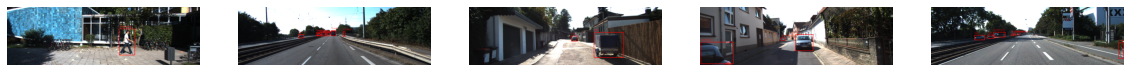

In [23]:
# Dataset paths
image_dir = "/data/notebook_files/training/image_2"
label_dir = "/data/notebook_files/training/label_2"

# Get sorted lists of image and label files
image_files = sorted(os.listdir(image_dir))
label_files = sorted(os.listdir(label_dir))

# Select the first 5 images for visualization
num_visualizations = 5
image_files = image_files[:num_visualizations]
label_files = label_files[:num_visualizations]

# Create a figure for multiple images
fig, axes = plt.subplots(1, num_visualizations, figsize=(20, 5))

# Loop through selected images
for i, (img_file, lbl_file) in enumerate(zip(image_files, label_files)):
    image_path = os.path.join(image_dir, img_file)
    label_path = os.path.join(label_dir, lbl_file)

    # Load image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Could not load image {image_path}")
        continue
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Read label file
    with open(label_path, "r") as f:
        labels = f.readlines()

    # Draw bounding boxes
    for label in labels:
        parts = label.split()
        class_name = parts[0]
        x1, y1, x2, y2 = map(float, [parts[4], parts[5], parts[6], parts[7]])

        # Convert to integer
        x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)

        # Draw bounding box
        cv2.rectangle(image, (x1, y1), (x2, y2), (255, 0, 0), 2)

        # Put class label
        cv2.putText(image, class_name, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)

    # Show image in grid
    axes[i].imshow(image)
    axes[i].axis("off")
 

In [30]:
# Define augmentation pipeline
transform = A.Compose([
    A.Resize(640, 480),  # Resize images
    A.HorizontalFlip(p=0.5),  # Random flip
    A.RandomBrightnessContrast(p=0.3),  # Adjust brightness & contrast
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),  # Normalize
    ToTensorV2(),  # Convert to tensor
])

In [32]:
# Paths
output_dir = "/data/notebook_files/kitti_dataset/images/train/processed_images"
os.makedirs(output_dir, exist_ok=True)

# Get all images
image_files = sorted(os.listdir(TRAINING_IMAGE_DIR))
total_images = len(image_files)
batch_size = 200  # Process 200 images at a time

In [31]:
# Process images in batches
for i in range(0, total_images, batch_size):
    batch_files = image_files[i : i + batch_size]  # Get batch
    
    for j, img_file in tqdm(enumerate(batch_files)):
        image_path = os.path.join(image_dir, img_file)
        image = cv2.imread(image_path)
        
        if image is None:
            print(f"Error loading image: {image_path}")
            continue

        # Convert to RGB
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Apply transformations
        augmented = transform(image=image)
        processed_image = augmented["image"]

        # Convert for saving
        processed_image = processed_image.permute(1, 2, 0).cpu().numpy() * 255
        processed_image = processed_image.astype(np.uint8)

        # Save processed image
        save_path = os.path.join(output_dir, img_file)
        cv2.imwrite(save_path, processed_image)

    # Free memory after each batch
    gc.collect()

print("Data preprocessing is done.")

Processed 0/7481
Processed 100/7481
Processed 200/7481
Processed 300/7481
Processed 400/7481
Processed 500/7481
Processed 600/7481
Processed 700/7481
Processed 800/7481
Processed 900/7481
Processed 1000/7481
Processed 1100/7481
Processed 1200/7481
Processed 1300/7481
Processed 1400/7481
Processed 1500/7481
Processed 1600/7481
Processed 1700/7481
Processed 1800/7481
Processed 1900/7481
Processed 2000/7481
Processed 2100/7481
Processed 2200/7481
Processed 2300/7481
Processed 2400/7481
Processed 2500/7481
Processed 2600/7481
Processed 2700/7481
Processed 2800/7481
Processed 2900/7481
Processed 3000/7481
Processed 3100/7481
Processed 3200/7481
Processed 3300/7481
Processed 3400/7481
Processed 3500/7481


KeyboardInterrupt: KeyboardInterrupt

# Preperare Lables for YOLO

We have to change the label formate from KITTI's version to one, YOLO can use for training. This mainly concerns the bboxes. We also used a mapping to replace the labels with indexes. The new data labels are saved alongside the original labels. We also removed the label `DontCare`, which results in a big reduction in bboxes.  

In [5]:
class_mapping = {
    "Pedestrian": 0, "Truck": 1, "Car": 2, "Cyclist": 3,
    "DontCare": 4, "Misc": 5, "Van": 6, "Tram": 7, "Person_sitting": 8
}

reverse_class_mapping = {v: k for k, v in class_mapping.items()}

In [6]:
# https://github.com/shreydan/yolo-object-detection-kitti/blob/main/kitti-data-yolo-conversion.ipynb
def convert_to_yolo_bbox(bbox, image_size):
    """Convert KITTI bbox (left, right, top, bottom) to YOLO format."""
    img_w, img_h = image_size
    x_center = ((bbox[0] + bbox[1]) / 2) / img_w
    y_center = ((bbox[2] + bbox[3]) / 2) / img_h
    width = (bbox[1] - bbox[0]) / img_w
    height = (bbox[3] - bbox[2]) / img_h
    return (x_center, y_center, width, height)

def yolo_to_bbox(x_center, y_center, width, height, img_w, img_h):
    """Convert YOLO bbox (normalized) back to pixel coordinates."""
    box_w = width * img_w
    box_h = height * img_h
    cx = x_center * img_w
    cy = y_center * img_h
    x_min = int(cx - box_w / 2)
    y_min = int(cy - box_h / 2)
    x_max = int(cx + box_w / 2)
    y_max = int(cy + box_h / 2)
    return max(0, x_min), max(0, y_min), min(img_w, x_max), min(img_h, y_max)  # Clamping to image bounds


def read_image_size(img_path):
    return Image.open(img_path).size

In [76]:
def parse_sample_fast(lbl_path, image_size, class_mapping):
    yolo_labels = []
    with open(lbl_path, 'r') as csv_file:
        reader = csv.reader(csv_file, delimiter=' ')
        for row in reader:
            if len(row) < 15:
                continue  # skip malformed lines

            class_name = row[0]
            if class_name == 'DontCare' or class_name not in class_mapping:
                continue
            
            class_id = class_mapping[class_name]
            bbox = (
                float(row[4]),  # bbox2_left
                float(row[6]),  # bbox2_right
                float(row[5]),  # bbox2_top
                float(row[7])   # bbox2_bottom
            )
            yolo_bbox = convert_to_yolo_bbox(bbox, image_size)
            yolo_labels.append((class_id, *yolo_bbox))

    return yolo_labels

# Pre-cache image sizes
print("Pre-loading image sizes...")
image_sizes = {}
for img_file in tqdm(os.listdir(TRAINING_IMAGE_DIR), desc="Loading image sizes"):
    if img_file.endswith(".png"):
        img_path = os.path.join(TRAINING_IMAGE_DIR, img_file)
        image_sizes[img_file] = Image.open(img_path).size

# Conversion loop
os.makedirs(output_label_dir, exist_ok=True)
print("Converting labels...")

for label_file in tqdm(os.listdir(TRAINING_LABEL_DIR), desc="Converting labels"):
    if not label_file.endswith(".txt"):
        continue
    
    lbl_path = os.path.join(TRAINING_LABEL_DIR, label_file)
    img_filename = label_file.replace(".txt", ".png")

    if img_filename not in image_sizes:
        continue  # Skip if image size is missing
    
    yolo_labels = parse_sample_fast(lbl_path, image_sizes[img_filename], class_mapping)
    
    output_label_path = os.path.join(output_label_dir, label_file)
    with open(output_label_path, 'w') as f:
        for lbl in yolo_labels:
            f.write(f"{lbl[0]} {' '.join(f'{v:.6f}' for v in lbl[1:])}\n")

Pre-loading image sizes...
Converting labels...


Converting labels: 100%|██████████| 7481/7481 [33:48<00:00,  3.69it/s]


In [10]:
YOLO_TRAINING_LABEL_DIR = "/data/notebook_files/kitti_dataset/labels/train/yolo_labels"

In [7]:
def yolo_to_bbox(x_center, y_center, width, height, img_width, img_height):
    """
    Convert YOLO format bounding box to corner coordinates.
    
    Parameters:
    - x_center, y_center: Center coordinates (normalized) of the bounding box.
    - width, height: Width and height (normalized) of the bounding box.
    - img_width, img_height: Dimensions of the image in pixels.
    
    Returns:
    - x_min, y_min, x_max, y_max: Corner coordinates of the bounding box in pixels.
    """
    # Convert normalized coordinates to absolute pixel values
    box_width = width * img_width
    box_height = height * img_height
    center_x = x_center * img_width
    center_y = y_center * img_height

    # Calculate the top-left corner
    x_min = int(center_x - (box_width / 2))
    y_min = int(center_y - (box_height / 2))
    
    # Calculate the bottom-right corner
    x_max = int(center_x + (box_width / 2))
    y_max = int(center_y + (box_height / 2))
    
    return x_min, y_min, x_max, y_max

In [8]:
def show_yolo_image_with_bounding_boxes(image_path, label_path):
    """Visualize YOLO labels on the image."""
    image = cv2.imread(image_path)
    if image is None:
        raise FileNotFoundError(f"Could not load image at {image_path}.")

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    img_h, img_w = image.shape[:2]

    if not os.path.exists(label_path):
        raise FileNotFoundError(f"Could not find label file at {label_path}.")

    with open(label_path, "r") as f:
        labels = f.readlines()

    for label in labels:
        parts = label.strip().split()
        class_id = int(parts[0])
        x_center, y_center, width, height = map(float, parts[1:])
        x1, y1, x2, y2 = yolo_to_bbox(x_center, y_center, width, height, img_w, img_h)

        cv2.rectangle(image, (x1, y1), (x2, y2), (255, 0, 0), 2)
        cv2.putText(image, reverse_class_mapping[class_id], (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)

    plt.imshow(image)
    plt.axis("off")
    plt.show()

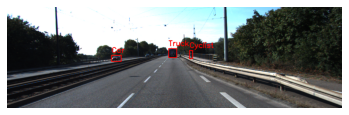

In [11]:
image_path = os.path.join(TRAINING_IMAGE_DIR, "000001.png")
label_path = os.path.join(YOLO_TRAINING_LABEL_DIR, "000001.txt")
show_yolo_image_with_bounding_boxes(image_path, label_path)

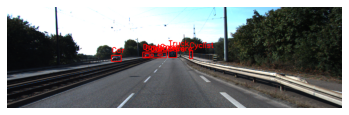

In [16]:
image_path = os.path.join(TRAINING_IMAGE_DIR, "000001.png")
label_path = os.path.join(TRAINING_LABEL_DIR, "000001.txt")
show_image_with_bounding_boxes(image_path, label_path)

# Sheet 6

In [3]:
import torch
import cv2
from ultralytics import YOLO
import os

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/home/datalore/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:

# Load the YOLOv8 model
model = YOLO('yolov8n.pt').to('cpu')


# Path to the input video
video_path = "/data/notebook_files/videos_train_00024.mp4"


videoCap = cv2.VideoCapture(video_path)


if not videoCap.isOpened():
    print("Error: Could not open video.")
    exit()


frame_width = int(videoCap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(videoCap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(videoCap.get(cv2.CAP_PROP_FPS))


output_path = "output_video.mp4"
fourcc = cv2.VideoWriter_fourcc(*"mp4v")
out = cv2.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height))


while videoCap.isOpened():
    ret, frame = videoCap.read()
    if not ret:
        break


    results = model.predict(frame, conf=0.5)


    for result in results:
        boxes = result.boxes.xyxy.cpu().numpy()  
        class_ids = result.boxes.cls.cpu().numpy()  
        confidences = result.boxes.conf.cpu().numpy()  

     
        class_names = model.names 

        for box, class_id, confidence in zip(boxes, class_ids, confidences):
            x1, y1, x2, y2 = map(int, box)  
            class_name = class_names[int(class_id)]  
            label = f"{class_name} {confidence:.2f}" 

            
            cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(frame, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

   
    out.write(frame)


    cv2.imshow("Perception", frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):  
        break


videoCap.release()
out.release()
cv2.destroyAllWindows()

print(f"Output video saved to: {output_path}")

In [ ]:
train_img_dir = "./training/image_2"
images = sorted(os.listdir(train_img_dir))
print(f"Number of training images: {len(images)}")

train_label_dir = "./training/label_2"
labels = sorted(os.listdir(train_label_dir))
print(f"Number of training labels: {len(labels)}")

In [ ]:
import os

video_path = "/data/notebook_files/videos_train_00024.mp4"
if not os.path.exists(video_path):
    print(f"Error: Video file not found at {video_path}")
else:
    print("Video file found.")

# Sheet 7

In [25]:
import os
import gc
import cv2
import csv
import glob
import torch
import numpy as np
from PIL import Image
from tqdm import tqdm
import albumentations as A
from ultralytics import YOLO
import matplotlib.pyplot as plt
from collections import Counter
from albumentations.pytorch import ToTensorV2
from concurrent.futures import ThreadPoolExecutor

# Constants
TRAINING_IMAGE_DIR = "/data/notebook_files/kitti_dataset/images/train/image_2"
TRAINING_PREPROCESED_IMAGE_DIR = "/data/notebook_files/kitti_dataset/images/train/processed_images"
TRAINING_LABEL_DIR = "/data/notebook_files/kitti_dataset/labels/train/label_2"
OUTPUT_LABEL_DIR = "/data/notebook_files/kitti_dataset/labels/train/yolo_labels"

# Class mapping
class_mapping = {
    "Pedestrian": 0, "Truck": 1, "Car": 2, "Cyclist": 3,
    "DontCare": 4, "Misc": 5, "Van": 6, "Tram": 7, "Person_sitting": 8
}
reverse_class_mapping = {v: k for k, v in class_mapping.items()}

# Ensure output directories exist
os.makedirs(TRAINING_PREPROCESED_IMAGE_DIR, exist_ok=True)
os.makedirs(OUTPUT_LABEL_DIR, exist_ok=True)

# Define augmentation pipeline
transform = A.Compose([
    A.Resize(640, 480),  # Resize images (adjust as needed)
    A.HorizontalFlip(p=0.5),  # Random flip
    A.RandomBrightnessContrast(p=0.3),  # Adjust brightness & contrast
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),  # Normalize
    ToTensorV2(),  # Convert to tensor
])

# Function to convert KITTI bbox to YOLO format
def convert_to_yolo_bbox(bbox, image_size):
    """Convert KITTI bbox (left, right, top, bottom) to YOLO format."""
    img_w, img_h = image_size
    x_center = ((bbox[0] + bbox[1]) / 2) / img_w
    y_center = ((bbox[2] + bbox[3]) / 2) / img_h
    width = (bbox[1] - bbox[0]) / img_w
    height = (bbox[3] - bbox[2]) / img_h
    return (x_center, y_center, width, height)

# Function to parse KITTI labels and convert to YOLO format
def parse_sample_fast(lbl_path, image_size, class_mapping):
    yolo_labels = []
    with open(lbl_path, 'r') as csv_file:
        reader = csv.reader(csv_file, delimiter=' ')
        for row in reader:
            if len(row) < 15:
                continue  # Skip malformed lines

            class_name = row[0]
            if class_name == 'DontCare' or class_name not in class_mapping:
                continue
            
            class_id = class_mapping[class_name]
            bbox = (
                float(row[4]),  # bbox2_left
                float(row[6]),  # bbox2_right
                float(row[5]),  # bbox2_top
                float(row[7])   # bbox2_bottom
            )
            yolo_bbox = convert_to_yolo_bbox(bbox, image_size)
            yolo_labels.append((class_id, *yolo_bbox))

    return yolo_labels

# Function to preprocess images and save them
def preprocess_images(image_dir, output_dir, transform, batch_size=200):
    """Preprocess images and save them to the output directory."""
    image_files = sorted(os.listdir(image_dir))
    total_images = len(image_files)

    for i in range(0, total_images, batch_size):
        batch_files = image_files[i : i + batch_size]  # Get batch
        
        for img_file in tqdm(batch_files, desc=f"Processing batch {i//batch_size + 1}"):
            image_path = os.path.join(image_dir, img_file)
            image = cv2.imread(image_path)
            
            if image is None:
                print(f"Error loading image: {image_path}")
                continue

            # Convert to RGB
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            # Apply transformations
            augmented = transform(image=image)
            processed_image = augmented["image"]

            # Convert for saving
            processed_image = processed_image.permute(1, 2, 0).cpu().numpy() * 255
            processed_image = processed_image.astype(np.uint8)

            # Save processed image
            save_path = os.path.join(output_dir, img_file)
            cv2.imwrite(save_path, processed_image)

        # Free memory after each batch
        gc.collect()

# Function to convert labels to YOLO format
def convert_labels_to_yolo(label_dir, output_label_dir, image_sizes, class_mapping):
    """Convert KITTI labels to YOLO format and save them."""
    for label_file in tqdm(os.listdir(label_dir), desc="Converting labels"):
        if not label_file.endswith(".txt"):
            continue
        
        lbl_path = os.path.join(label_dir, label_file)
        img_filename = label_file.replace(".txt", ".png")

        if img_filename not in image_sizes:
            continue  # Skip if image size is missing
        
        yolo_labels = parse_sample_fast(lbl_path, image_sizes[img_filename], class_mapping)
        
        output_label_path = os.path.join(output_label_dir, label_file)
        with open(output_label_path, 'w') as f:
            for lbl in yolo_labels:
                f.write(f"{lbl[0]} {' '.join(f'{v:.6f}' for v in lbl[1:])}\n")

# Function to process videos and draw bounding boxes
def process_video(video_path, output_path, model, transform):
    """Process a video, perform inference, and save the output with bounding boxes."""
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise FileNotFoundError(f"Could not open video at {video_path}.")

    # Get video properties
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = int(cap.get(cv2.CAP_PROP_FPS))

    # Define the codec and create VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height))

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Convert frame to RGB
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        # Apply transformations
        transformed = transform(image=frame_rgb)
        processed_frame = transformed["image"]

        # Perform inference (assuming model is already trained)
        with torch.no_grad():
            predictions = model(processed_frame.unsqueeze(0).to(device))

        # Draw bounding boxes on the frame
        for pred in predictions:
            x1, y1, x2, y2 = pred["bbox"]
            cv2.rectangle(frame, (x1, y1), (x2, y2), (255, 0, 0), 2)
            cv2.putText(frame, pred["class_name"], (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)

        
        out.write(frame)

    
    cap.release()
    out.release()
    cv2.destroyAllWindows()


if __name__ == "__main__":
    
    preprocess_images(TRAINING_IMAGE_DIR, TRAINING_PREPROCESED_IMAGE_DIR, transform)


    print("Pre-loading image sizes...")
    image_sizes = {}
    for img_file in tqdm(os.listdir(TRAINING_IMAGE_DIR), desc="Loading image sizes"):
        if img_file.endswith(".png"):
            img_path = os.path.join(TRAINING_IMAGE_DIR, img_file)
            image_sizes[img_file] = Image.open(img_path).size

  
    convert_labels_to_yolo(TRAINING_LABEL_DIR, OUTPUT_LABEL_DIR, image_sizes, class_mapping)

 
    video_path = "/data/notebook_files/videos_train_00024.mp4"
    output_path = "path/to/output/video.mp4"
    model = YOLO("yolov8n.pt")  
    process_video(video_path, output_path, model, transform)

    

Pre-loading image sizes...

WARNING ⚠️ torch.Tensor inputs should be normalized 0.0-1.0 but max value is 2.6399998664855957. Dividing input by 255.
0: 640x480 (no detections), 118.6ms
Speed: 0.0ms preprocess, 118.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


Converting labels: 100%|██████████| 7481/7481 [16:44<00:00,  7.45it/s]


IndexError: IndexError: too many indices for tensor of dimension 2